In [19]:
import logging
import os
import shutil
import time

from collections.abc import Callable
from typing import Type

import numpy as np
import torch

from matplotlib import pyplot as plt
from torch.nn import Linear
from torch_geometric.nn.conv import TransformerConv
from torch_geometric.data.data import Data

from decoders.beam_search_decoder import beam_search_decode
from decoders.naive import naive_decode
from solvers.concorde_solver import concorde_solve
from solvers.heuristic import closest_node_solve
from utils import compute_route_length, plot_route, plot_loss
from tsp import generate_random_graph, generate_dataset, import_dataset

Probabilities: Type = torch.Tensor
Embeddings: Type = torch.Tensor

logger = logging.getLogger(__name__)

# Graph Neural Network and Hyperparameters

In [20]:
NUM_NODES: int = 30
NUM_GRAPHS: int = 1_000
NUM_VAL_GRAPHS: int = 200
NUM_TEST_GRAPHS: int = 50
NUM_EPOCHS: int = 150
EARLY_STOPPING_MIN_DELTA: float = 1e-9
EARLY_STOPPING_PATIENCE: int = 10  # number of epochs to tolerate no validation loss improvement

EMBEDDING_DIMENSIONS: int = 32
MLP_NUM_NEURONS: int = 1024
ADAM_LR: float = 1e-3


class Net(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        num_edge_features: int,
        transformer_neuron_count: int,
        mlp_neuron_count: int,
        embedding_dimensions: int,
    ) -> None:
        super().__init__()
        self.conv1 = TransformerConv(num_node_features, transformer_neuron_count, edge_dim=num_edge_features)
        self.conv2 = TransformerConv(transformer_neuron_count, embedding_dimensions, edge_dim=num_edge_features)
        self.mlp1 = Linear((2 * embedding_dimensions) + num_edge_features, mlp_neuron_count)
        self.mlp2 = Linear(mlp_neuron_count, 1)

    def forward(
        self,
        data: Data,
    ) -> tuple[Probabilities, Embeddings]:
        x: torch.Tensor = data.x
        edge_index: torch.Tensor = data.edge_index
        edge_attr: torch.Tensor = data.edge_attr

        # generate node embeddings
        embeddings: torch.Tensor = self.conv1(x, edge_index, edge_attr=edge_attr).tanh()
        embeddings = self.conv2(embeddings, edge_index, edge_attr=edge_attr).tanh()

        # order-invariant lookup of edge source/destination nodes into node embeddings
        source_embeddings = embeddings[edge_index[0, :]]
        destination_embeddings = embeddings[edge_index[1, :]]

        # decode node embeddings into edge probabilities
        flattened_embeddings = torch.concat((source_embeddings, destination_embeddings, edge_attr), dim=1)
        probs = self.mlp1(flattened_embeddings).relu()
        probs = self.mlp2(probs).sigmoid()

        return probs, embeddings

# Node / Edge Feature Generation and Data Reshaping

In [21]:
def get_nodes_within_threshold(points: torch.Tensor, threshold: float = 0.1) -> torch.Tensor:
    """
    For each node in a TSP, get the number of nodes within a distance that is under the threshold (default 0.1).
    Used to generate the "connectedness" feature.
    """
    assert threshold > 0.0

    xs, ys = points[0:2]

    # reshape xs and ys, so we can compute this for every node in one operation
    xs_expanded: torch.Tensor = xs[:, None] @ torch.ones_like(xs)[None, :]
    xs_distances: torch.Tensor = torch.abs(xs_expanded - xs[None, :])
    xs_under_threshold: torch.Tensor = torch.le(xs_distances, threshold)

    ys_expanded: torch.Tensor = ys[:, None] @ torch.ones_like(ys)[None, :]
    ys_distances: torch.Tensor = torch.abs(ys_expanded - ys[None, :])
    ys_under_threshold: torch.Tensor = torch.le(ys_distances, threshold)

    final = torch.logical_and(xs_under_threshold, ys_under_threshold)
    num_under_threshold = final.sum(dim=1)

    return num_under_threshold


def generate_node_features(points: torch.Tensor) -> torch.Tensor:
    """
    Generate features for a set of points. Add features here at will - the rest of the code should keep up.
    """
    xs = points[0, :]
    ys = points[1, :]

    adjacency = get_nodes_within_threshold(points, 0.1)
    return torch.vstack((xs, ys, adjacency))


def convert_tsp_to_torch_dataset(
    num_nodes: int = 1000,
    points: torch.Tensor | None = None,
    route: list[int] | None = None,
) -> Data:
    """
    Generate/convert the TSP dataset into the format used by torch-geometric
    """

    all_edges: list[tuple[int, int]] = [(u, v) for u in range(num_nodes) for v in range(num_nodes)]

    edge_index_tensor: torch.Tensor = torch.tensor(all_edges).t().contiguous()
    if (route is None and points is not None) or (points is None and route is not None):
        raise ValueError("You must specify either both route and points, or neither.")

    if points is None or route is None:
        points = generate_random_graph(num_nodes, render=False)
        route = concorde_solve(points)

    points_t: torch.Tensor = points.t()

    # generate a lookup table which maps an edge onto the "weight" (length)
    edge_weights: dict[tuple, float] = {
        edge: float(torch.dist(points_t[edge[0]], points_t[edge[1]])) for edge in all_edges
    }

    # generate a lookup table which maps an edge onto its "feature" (exponentially decayed importance)
    edge_features: dict[tuple, float] = {
        edge: float(torch.exp(-torch.dist(points_t[edge[0]], points_t[edge[1]]))) for edge in all_edges
    }

    # generate the edge attributes (features)
    edge_attributes: torch.Tensor = torch.tensor(
        [
            (edge_weights[tuple(edge)], edge_features[tuple(edge)])
            for edge in all_edges
        ]
    )

    # create the probability matrix by unpacking the Concorde route
    y = torch.zeros(edge_index_tensor.shape[1])
    for u, v in zip(route[:-1], route[1:]):
        y[all_edges.index((u, v))] = 1

    # add the last hop from end to start
    y[all_edges.index((route[-1], route[0]))] = 1

    return Data(
        x=generate_node_features(points).t(),
        edge_index=edge_index_tensor,
        edge_attr=edge_attributes,
        y=y,
    )


# Training, Validation, and Testing Loops

In [22]:
@torch.no_grad()
def validate(val_dataset: list[Data], nn: Net, loss: torch.nn.BCELoss) -> torch.Tensor:
    """
    Calculate the validation loss given a certain dataset, network, and loss function.
    """
    avg_val_loss: torch.Tensor = torch.zeros(())
    for val_graph in val_dataset:
        out, _ = nn(val_graph)
        val_loss = loss(out, val_graph.y[:, None])
        avg_val_loss += val_loss

    return avg_val_loss / len(val_dataset)


def train(nn: Net, dataset: list[Data], val_dataset: list[Data], render: bool = False) -> Net:
    """
    Train a network on a given dataset, using the validation data after each epoch.
    """
    epochs_without_improvement = 0
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(nn.parameters(), lr=ADAM_LR)

    # training history for plot
    train_loss_history = []
    val_loss_history = []
    min_val_losses = []

    for epoch in range(NUM_EPOCHS):
        # plot solutions to some of the validation problems and save to files for rendering
        if render:
            for idx, unseen_example in enumerate(val_dataset[:5]):
                out, _ = nn(unseen_example)
                solution = beam_search_decode(
                    unseen_example.x[:, 0:2].t(), 
                    out, 
                    beam_width_mapping=lambda ri: 2 if ri < NUM_NODES // 2 else 1,
                )
                plot_route(unseen_example.x[:, 0:2].t(), solution, show=False)
                plt.savefig(f"render/inc-solve/problem_{idx:0>5}_solution_{epoch:0>5}.png")
                plt.clf()

        avg_train_loss = torch.zeros(1)

        nn.train()
        for _graph in dataset:
            optimizer.zero_grad()
            out, embeddings = nn(_graph)
            train_loss = loss(out, _graph.y[:, None])
            avg_train_loss += train_loss

            train_loss.backward()
            optimizer.step()

        nn.eval()
        avg_val_loss = validate(val_dataset, nn, loss)
        avg_train_loss /= len(dataset)

        train_loss_history.append(avg_train_loss)
        min_val_loss = min(val_loss_history, default=9e99)
        val_loss_history.append(avg_val_loss)

        # if our new average validation loss is smaller than our previous minimum by MIN_DELTA or more, keep going
        if min_val_loss - avg_val_loss >= EARLY_STOPPING_MIN_DELTA:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        min_val_losses.append(min(val_loss_history))

        print(
            " | ".join(
                [
                    f"Epoch {epoch:<5}",
                    f"avg. train loss: {float(avg_train_loss):.5f}",
                    f"avg. val. loss: {float(avg_val_loss):.5f}",
                    f"min. val. loss: {min_val_loss if epoch else 0.:.5f}",
                ]
            )
        )

        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            print("Stopping early due to no validation loss improvement.")
            break

    plot_loss(train_loss_history, val_loss_history, min_val_losses)
    return nn


def evaluate(
    nn: Net,
    evaluate_dataset: list[Data],
    render_until: int = 1,
    verbose: bool = True,
    beam_width_func: Callable[[int], [int]] = lambda rl: 2 if rl < 8 else 1,
) -> tuple[float, ...]:
    """
    Evaluate a neural network using the given evaluation data.

    :param nn: a graph neural network
    :param evaluate_dataset: the dataset to use for evaluation
    :param render_until: draw solution comparisons until this number of solutions is processed
    :param verbose: print final results of evaluation
    :param beam_width_func: see beam_search_decode's beam_width_func parameter
    """
    # random, concorde, naive_neural, beam_neural
    titles = "closest node", "naive neural", "beam neural", "concorde"
    average_lengths = np.zeros(4)

    for data_idx, _data in enumerate(evaluate_dataset):
        points = torch.vstack((_data.x[:, 0], _data.x[:, 1]))
        nn_output, _ = nn(_data)
        solutions = [
            closest_node_solve(points),
            torch.tensor(naive_decode(nn_output)),
            torch.tensor(beam_search_decode(points, nn_output, beam_width_func)),
            torch.tensor(naive_decode(_data.y)),
        ]

        route_lengths = np.array([compute_route_length(points, route) for route in solutions])
        average_lengths += route_lengths

        if data_idx < render_until:
            plt.figure(figsize=(27, 9))
            for idx, solution in enumerate(solutions):
                plt.subplot(1, len(average_lengths), idx + 1)
                plt.title(titles[idx] + f"({float(route_lengths[idx]):.3f})")
                plot_route(points, solution, show=False)

            plt.show()

    average_lengths /= len(evaluate_dataset)

    if verbose:
        print("Average distances: ")
        for solution_name, avg_distance in zip(titles, average_lengths):
            print(f"\t{solution_name:>25}: {avg_distance:.3f}")

    return average_lengths

# Dataset Generation and Loading

In [23]:
# generate and/or import all datasets from disk
generate_dataset(NUM_NODES, NUM_GRAPHS, "train")
train_points, train_solutions = import_dataset(NUM_NODES, NUM_GRAPHS, "train")

generate_dataset(NUM_NODES, NUM_VAL_GRAPHS, "validation")
val_points, val_solutions = import_dataset(NUM_NODES, NUM_VAL_GRAPHS, "validation")

generate_dataset(NUM_NODES, NUM_TEST_GRAPHS, "test")
test_points, test_solutions = import_dataset(NUM_NODES, NUM_TEST_GRAPHS, "test")

training_dataset = [
    convert_tsp_to_torch_dataset(NUM_NODES, train_point, train_solution)
    for train_point, train_solution in zip(train_points, train_solutions)
]
validation_dataset = [
    convert_tsp_to_torch_dataset(NUM_NODES, val_point, val_solution)
    for val_point, val_solution in zip(val_points, val_solutions)
]
test_dataset = [
    convert_tsp_to_torch_dataset(NUM_NODES, test_point, test_solution)
    for test_point, test_solution in zip(test_points, test_solutions)
]

# Train and Test the Network

Epoch 0     | avg. train loss: 0.09792 | avg. val. loss: 0.08410 | min. val. loss: 0.00000
Epoch 1     | avg. train loss: 0.08116 | avg. val. loss: 0.07989 | min. val. loss: 0.08410
Epoch 2     | avg. train loss: 0.07891 | avg. val. loss: 0.07848 | min. val. loss: 0.07989
Epoch 3     | avg. train loss: 0.07813 | avg. val. loss: 0.07796 | min. val. loss: 0.07848
Epoch 4     | avg. train loss: 0.07770 | avg. val. loss: 0.07765 | min. val. loss: 0.07796
Epoch 5     | avg. train loss: 0.07740 | avg. val. loss: 0.07749 | min. val. loss: 0.07765
Epoch 6     | avg. train loss: 0.07717 | avg. val. loss: 0.07723 | min. val. loss: 0.07749
Epoch 7     | avg. train loss: 0.07698 | avg. val. loss: 0.07710 | min. val. loss: 0.07723
Epoch 8     | avg. train loss: 0.07681 | avg. val. loss: 0.07685 | min. val. loss: 0.07710
Epoch 9     | avg. train loss: 0.07666 | avg. val. loss: 0.07674 | min. val. loss: 0.07685
Epoch 10    | avg. train loss: 0.07652 | avg. val. loss: 0.07664 | min. val. loss: 0.07674

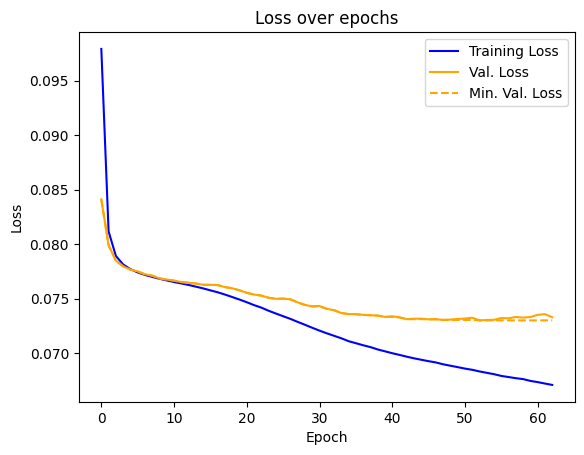

In [24]:
# create graph neural network
net = Net(
    num_node_features=training_dataset[0].x.shape[1],
    num_edge_features=training_dataset[0].edge_attr.shape[1],
    transformer_neuron_count=8,
    embedding_dimensions=EMBEDDING_DIMENSIONS,
    mlp_neuron_count=MLP_NUM_NEURONS,
)

# do training and save weights to disk
train(net, training_dataset, validation_dataset)
torch.save(net.state_dict(), "./net_trained")

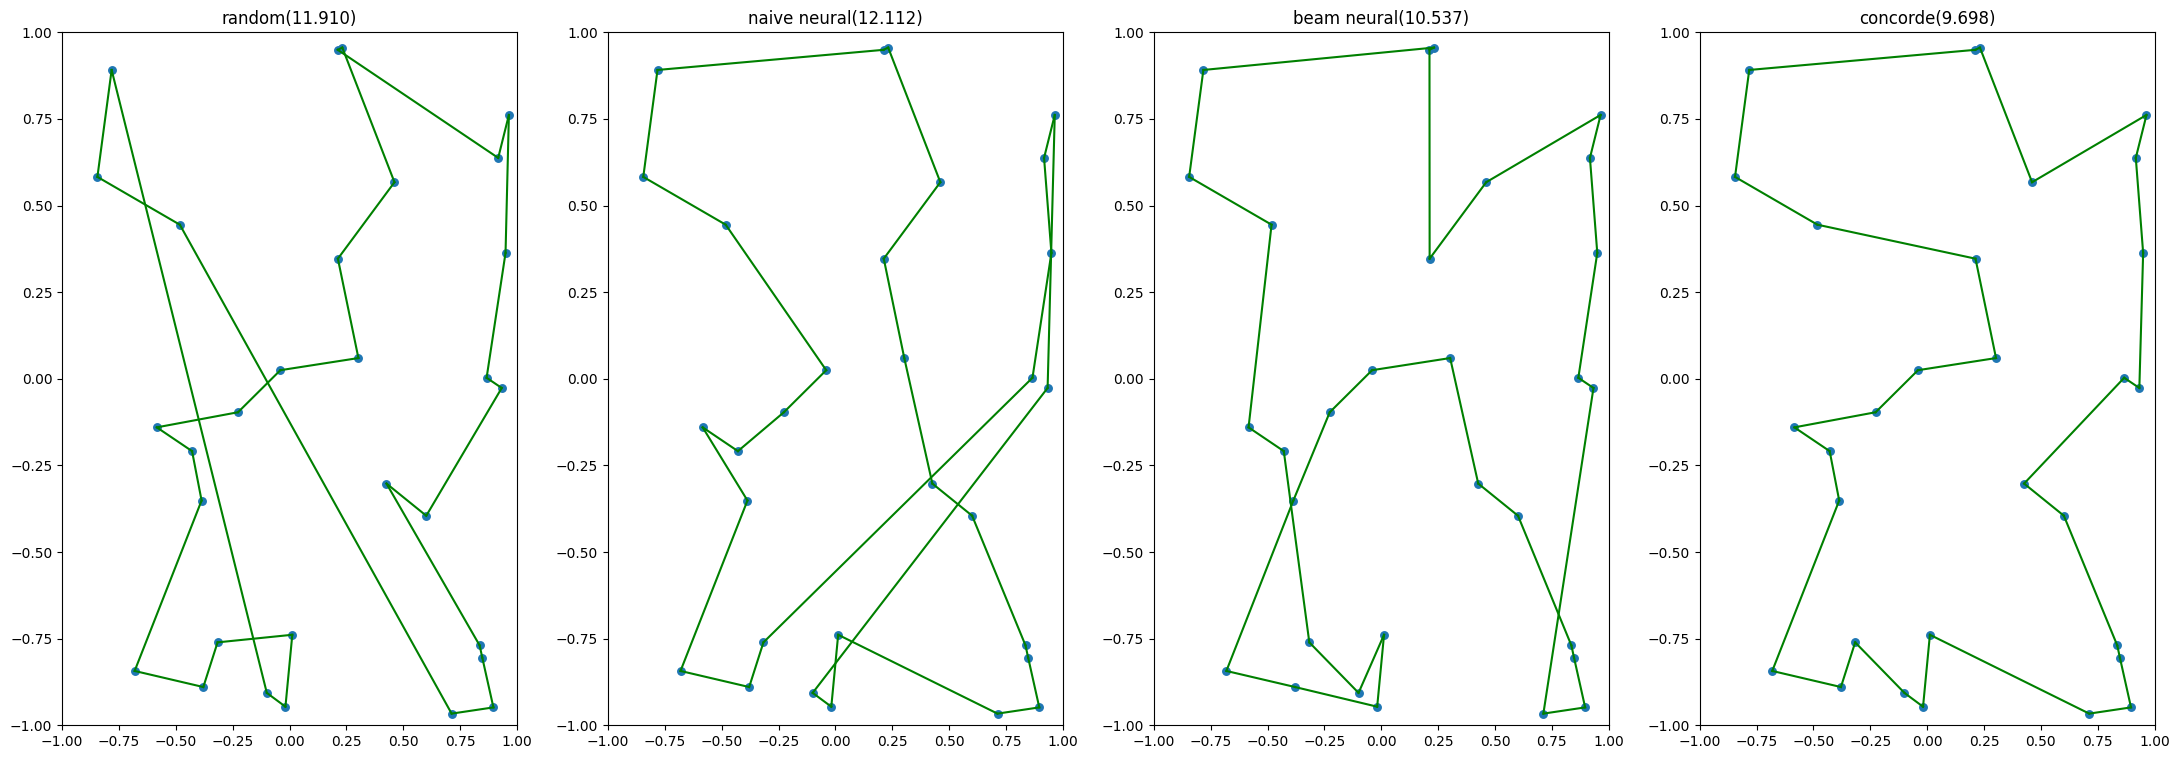

Average distances: 
	                   random: 10.876
	             naive neural: 10.820
	              beam neural: 9.869
	                 concorde: 9.077


array([10.87550339, 10.81989082,  9.86942482,  9.07656494])

In [25]:
# load network weights from disk (for eval, timing and plotting code)
net.load_state_dict(torch.load("./net_trained"))
net.eval()
evaluate(net, test_dataset)

# Generate some informative plots and render clips

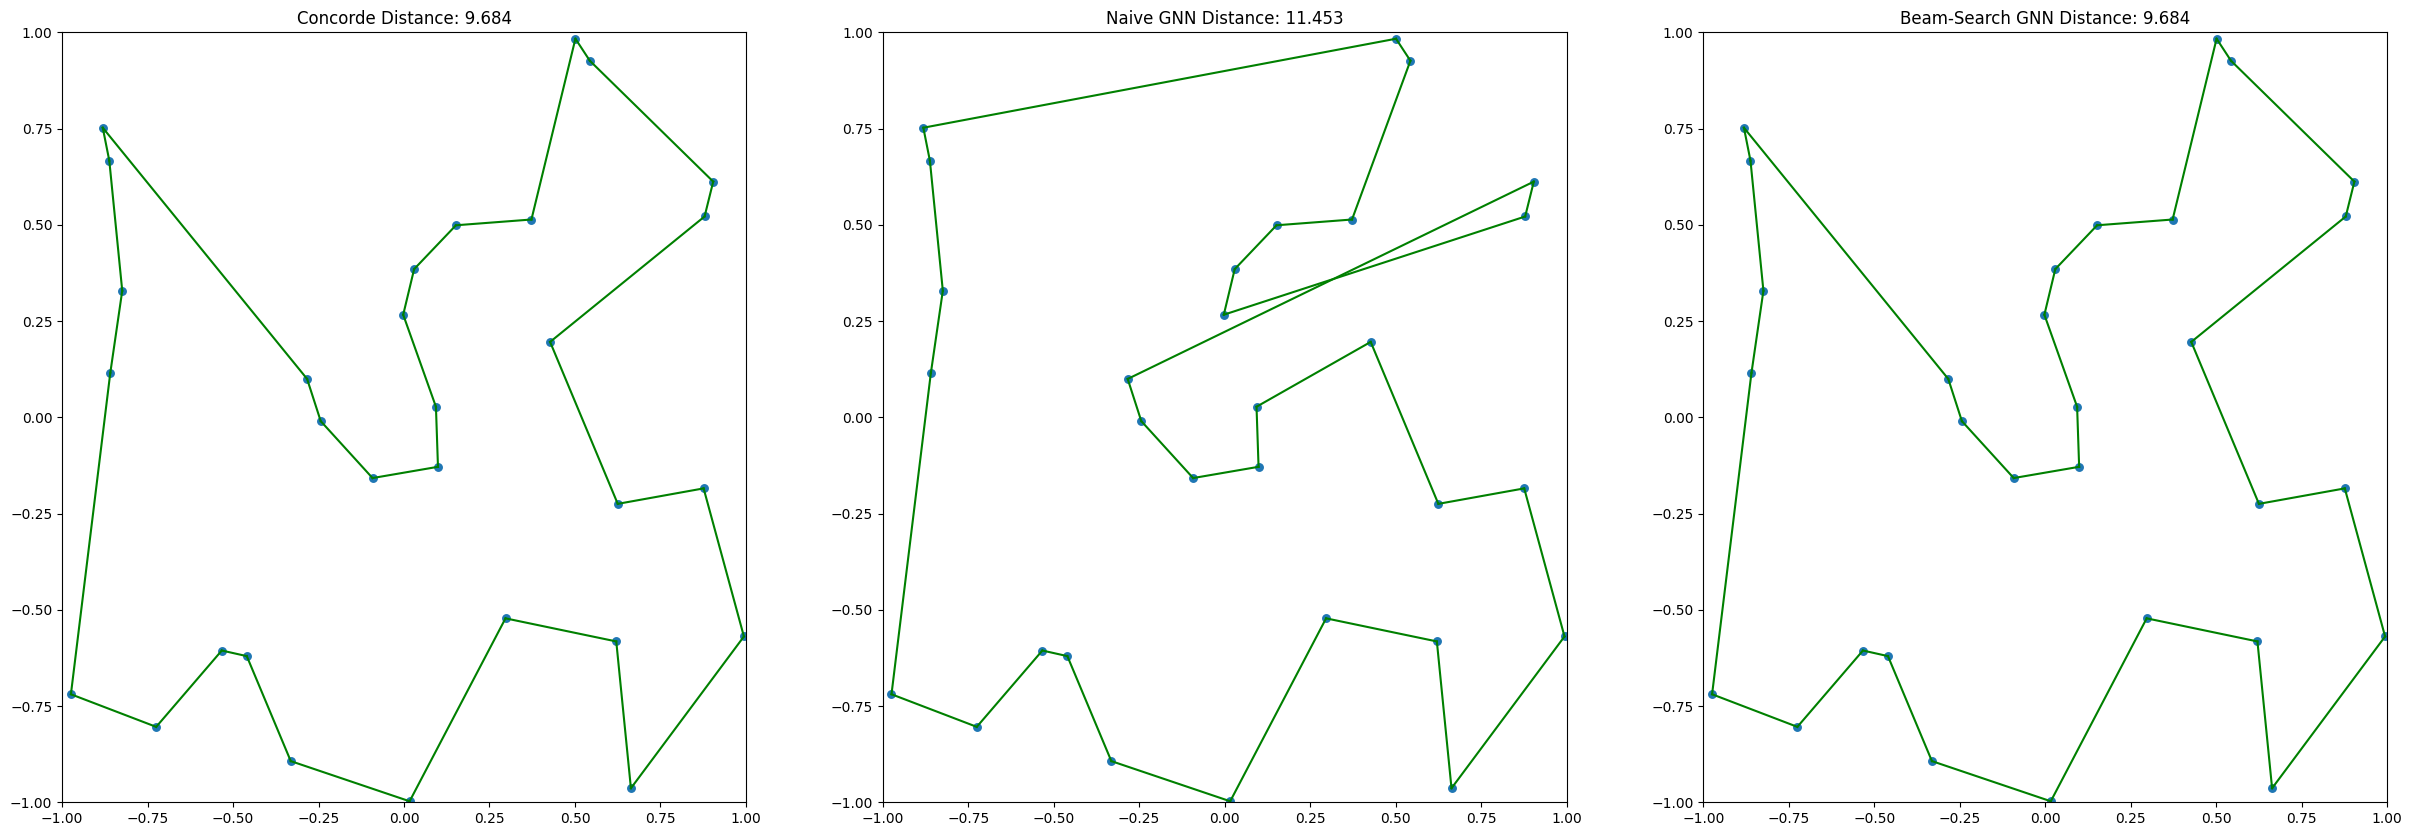

In [37]:
# peel off an individual sample from the training data and inspect it.
# change sample below to a number between 0 and NUM_NODES (exclusive) to inspect different graphs.
sample = 1
inspect_points = training_dataset[sample].x.t()

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
concorde_solution = naive_decode(training_dataset[sample].y)
concorde_distance = float(compute_route_length(inspect_points, torch.tensor(concorde_solution)))
plt.title(f"Concorde Distance: {concorde_distance:.3f}")
plot_route(inspect_points[0:2], concorde_solution, show=False)

plt.subplot(1, 3, 2)
naive_nn_solution = torch.tensor(naive_decode(net(training_dataset[sample])[0]))
naive_nn_distance = float(compute_route_length(inspect_points, naive_nn_solution))
plt.title(f"Naive GNN Distance: {naive_nn_distance:.3f}")
plot_route(inspect_points[0:2], naive_nn_solution, show=False)

plt.subplot(1, 3, 3)
beam_nn_solution = torch.tensor(
    beam_search_decode(
        inspect_points,
        net(training_dataset[sample])[0],
        lambda partial_route_length: (1 if partial_route_length > 12 else 2) if partial_route_length > 4 else 3,
    )
)
beam_nn_distance = float(compute_route_length(inspect_points, beam_nn_solution))
plt.title(f"Beam-Search GNN Distance: {beam_nn_distance:.3f}")
plot_route(inspect_points[0:2], beam_nn_solution)

In [27]:
# move concorde tmp files into a tmp/ directory for easier deletion.
def cleanup() -> None:
    try:
        os.mkdir("tmp")
    except FileExistsError:
        pass

    bad_files = [
        filename 
        for filename in os.listdir() 
        if filename.endswith(".res") 
           or filename.endswith(".sav") 
           or filename.endswith(".pul")
    ]
    for bad_file in bad_files:
        shutil.move(f"./{bad_file}", "tmp/")

cleanup()

In [28]:
def calculate_closest_node_runtimes(dataset: list[Data]) -> float:
    runtime = 0.0

    for data_idx, _data in enumerate(dataset):
        points = torch.vstack((_data.x[:, 0], _data.x[:, 1]))

        start = time.process_time_ns()
        _ = closest_node_solve(points)
        end = time.process_time_ns()

        runtime += end - start

    runtime /= len(dataset)
    return runtime


def calculate_nn_runtimes(
    nn: Net,
    dataset: list[Data],
    naive: bool = True,
    beam_width_func: Callable[[int], [int]] = lambda rl: 2 if rl < 10 else 1,
) -> float:
    neural = 0.0

    for data_idx, _data in enumerate(dataset):
        points = torch.vstack((_data.x[:, 0], _data.x[:, 1]))

        if naive:
            start = time.process_time_ns()
            _ = torch.tensor(naive_decode(nn(_data)[0]))
            end = time.process_time_ns()
        else:
            start = time.process_time_ns()
            _ = torch.tensor(
                beam_search_decode(
                    points,
                    nn(_data)[0],
                    beam_width_func,
                )
            )
            end = time.process_time_ns()

        neural += end - start

    neural /= len(dataset)
    return neural

# Generate timing data

In [29]:
# net.load_state_dict(torch.load("./net_trained"))
num_trials: int = 100
all_timing_num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
closest_ys = []
naive_ys = []
beam_ys = []

solo_beam_width_probability: dict[int, float] = {i: np.exp((8 - i) / 3) for i in range(1, 41)}


# decay probability of beam width 2 proportional to how far along the route we are
def stepped_beam_width_function(partial_route_length: int) -> int:
    if np.random.random() > solo_beam_width_probability[partial_route_length]:
        return 1
    return 2


def default_beam_width_function(partial_route_length: int) -> int:
    if partial_route_length < 10:
        return 2
    return 1


print(f"{'N':>5}  {'Closest':^15} {'Naive':^15} {'Beam':^15}")
for timing_num_nodes in all_timing_num_nodes:
    generate_dataset(timing_num_nodes, num_trials, "test")
    all_timing_points, all_timing_solutions = import_dataset(timing_num_nodes, num_trials, "test")

    timing_dataset = [
        convert_tsp_to_torch_dataset(timing_num_nodes, timing_points, timing_solution)
        for timing_points, timing_solution in zip(all_timing_points, all_timing_solutions)
    ]

    closest_node_runtime = calculate_closest_node_runtimes(timing_dataset)
    naive_runtime = calculate_nn_runtimes(net, timing_dataset)
    beam_runtime = calculate_nn_runtimes(net, timing_dataset, naive=False, beam_width_func=stepped_beam_width_function)

    closest_ys.append(closest_node_runtime / 1e9)
    naive_ys.append(naive_runtime / 1e9)
    beam_ys.append(beam_runtime / 1e9)
    print(f"{timing_num_nodes:>5}: {closest_node_runtime:^15} {naive_runtime:^15} {beam_runtime:^15}")


    N      Closest          Naive           Beam      
    5:     61470.0        376930.0        556650.0    
   10:    243590.0        532250.0        5402340.0   
   15:    540040.0        849660.0       11567140.0   
   20:    981420.0        1780680.0      19867780.0   
   25:    1492180.0       2031360.0      25210650.0   
   30:    2069050.0       2799750.0      31877580.0   
   35:    2983740.0       4337150.0      37719850.0   
   40:    3724580.0       5183610.0      44260950.0   


# Generate scoring data

In [30]:

num_trials: int = 100
scoring_all_num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]


closest_score_ys = []
naive_score_ys = []
beam_score_ys = []
concorde_score_ys = []

print(f"{'N':>5}  {'Closest':^15} {'Naive':^15} {'Beam':^15} {'Concorde':^15}")
for scoring_num_nodes in scoring_all_num_nodes:
    generate_dataset(scoring_num_nodes, num_trials, "test")
    all_scoring_points, all_scoring_solutions = import_dataset(scoring_num_nodes, num_trials, "test")

    scoring_dataset = [
        convert_tsp_to_torch_dataset(scoring_num_nodes, scoring_points, scoring_solution)
        for scoring_points, scoring_solution in zip(all_scoring_points, all_scoring_solutions)
    ]

    closest_node_score, naive_nn_score, beam_nn_score, concorde_score = evaluate(
        net,
        scoring_dataset,
        render_until=0,
        verbose=False,
        beam_width_func=stepped_beam_width_function,
    )
    closest_score_ys.append(closest_node_score)
    naive_score_ys.append(naive_nn_score)
    beam_score_ys.append(beam_nn_score)
    concorde_score_ys.append(concorde_score)

    print(
        f"{scoring_num_nodes:>5}: "
        f"{closest_node_score:^15.2f} "
        f"{naive_nn_score:^15.2f} "
        f"{beam_nn_score:^15.2f} "
        f"{concorde_score:^15.2f}"
    )

    N      Closest          Naive           Beam          Concorde    
    5:      4.50            4.51            4.36            4.35      
   10:      6.33            6.01            5.71            5.68      
   15:      7.68            7.38            6.81            6.73      
   20:      8.93            8.69            7.85            7.64      
   25:      9.99            9.73            8.69            8.40      
   30:      10.97           10.87           9.64            9.20      
   35:      11.67           11.76           10.45           9.71      
   40:      12.48           12.83           11.42           10.25     


# Render plots

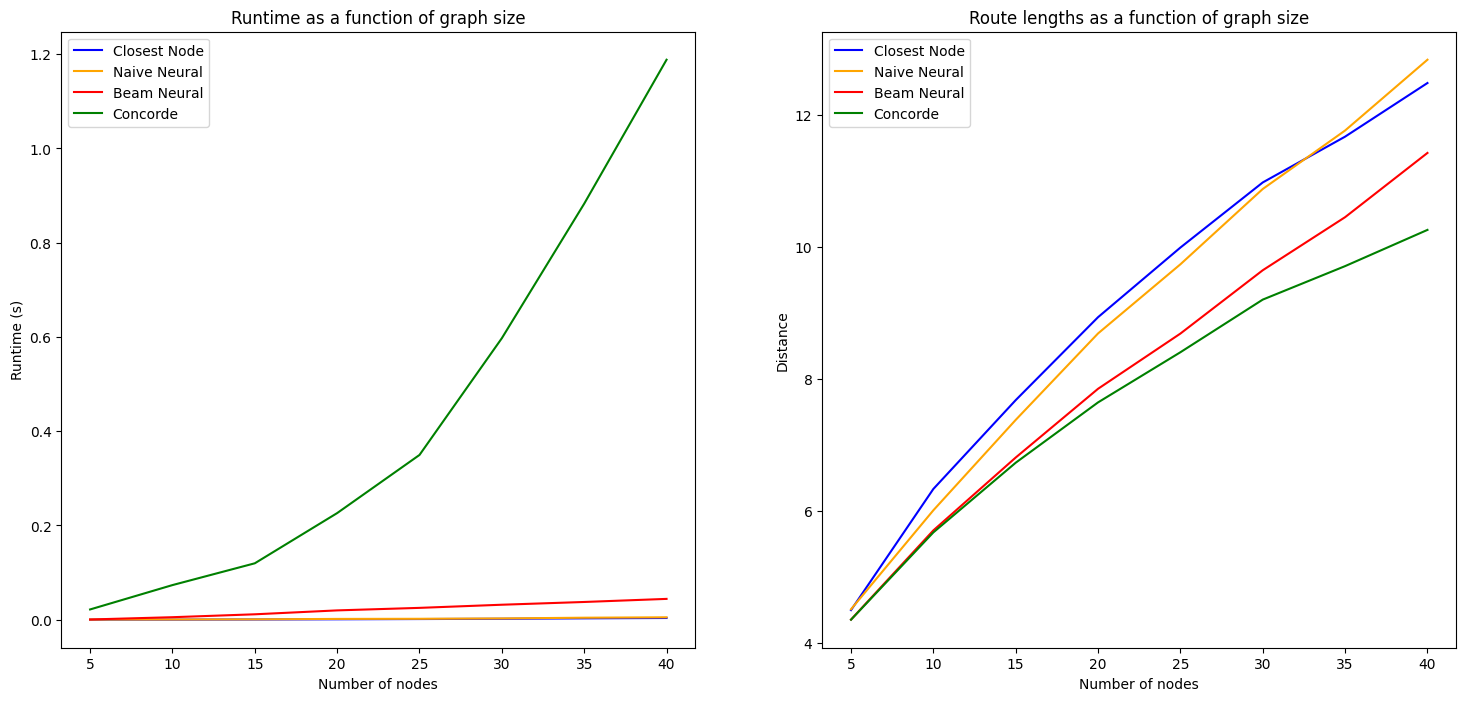

In [31]:
# use stored timings generated once because it takes a really long time to run. this was run with 500 repeats.
with open("conc_timings.csv", "r") as f:
    _ = f.readline()
    conc_ys = [float(y) for y in f.readline().split(",")]

plt.figure(figsize=(18, 8))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.title("Runtime as a function of graph size")
plt.xlabel("Number of nodes")
plt.ylabel("Runtime (s)")
plt.plot(scoring_all_num_nodes, closest_ys, label="Closest Node", color="blue")
plt.plot(scoring_all_num_nodes, naive_ys, label="Naive Neural", color="orange")
plt.plot(scoring_all_num_nodes, beam_ys, label="Beam Neural", color="red")
plt.plot(scoring_all_num_nodes, conc_ys, label="Concorde", color="green")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Route lengths as a function of graph size")
plt.xlabel("Number of nodes")
plt.ylabel("Distance")
plt.plot(scoring_all_num_nodes, closest_score_ys, label="Closest Node", color="blue")
plt.plot(scoring_all_num_nodes, naive_score_ys, label="Naive Neural", color="orange")
plt.plot(scoring_all_num_nodes, beam_score_ys, label="Beam Neural", color="red")
plt.plot(scoring_all_num_nodes, concorde_score_ys, label="Concorde", color="green")
plt.legend()

# plt.savefig("runtime_and_soln_lengths_stepped")
plt.show()

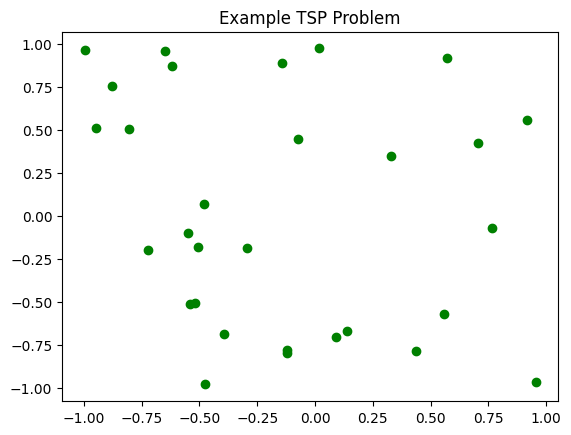

In [32]:
plt.scatter(*training_dataset[0].x[:, [0, 1]].t(), color="green")
plt.title("Example TSP Problem")
plt.show()

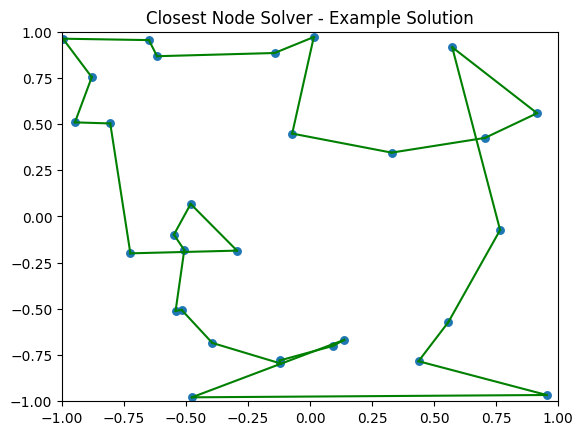

In [33]:
cnroute = closest_node_solve(training_dataset[0].x.t())
plt.title("Closest Node Solver - Example Solution")
plot_route(training_dataset[0].x[:, 0:2].t(), cnroute)

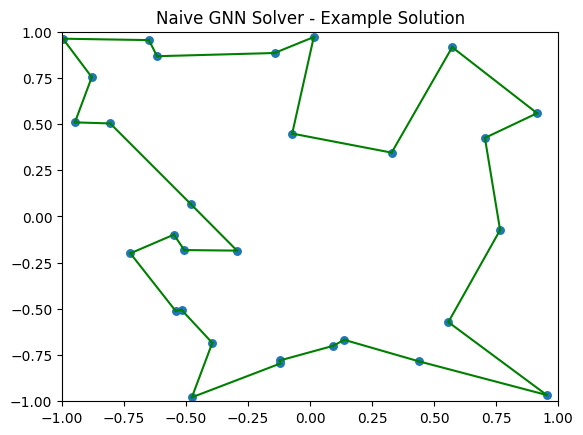

In [34]:
plt.title("Naive GNN Solver - Example Solution")
plot_route(training_dataset[0].x[:, 0:2].t(), naive_decode(training_dataset[0].y))

In [35]:
# render a full run of the beam search algorithm on an example problem
all_bsd_render_points, all_bsd_render_solutions = import_dataset(10, num_trials, "test")

bsd_render_dataset = [
    convert_tsp_to_torch_dataset(10, points=bsd_render_points, route=bsd_render_solution)
    for bsd_render_points, bsd_render_solution in zip(all_bsd_render_points, all_bsd_render_solutions)
]
bsd_render_idx = 2
bsd_render_graph = bsd_render_dataset[bsd_render_idx]
bsd_render_out, _ = net(bsd_render_graph)
bsd_render_points = torch.vstack((bsd_render_graph.x[:, 0], bsd_render_graph.x[:, 1]))
beam_search_decode(
    bsd_render_points,
    bsd_render_out,
    beam_width_mapping=lambda _: 2,
    render=True,
    render_prefix=f"problem_{bsd_render_idx}_",
)

[0, 3, 6, 4, 2, 9, 1, 7, 5, 8]

<Figure size 640x480 with 0 Axes>

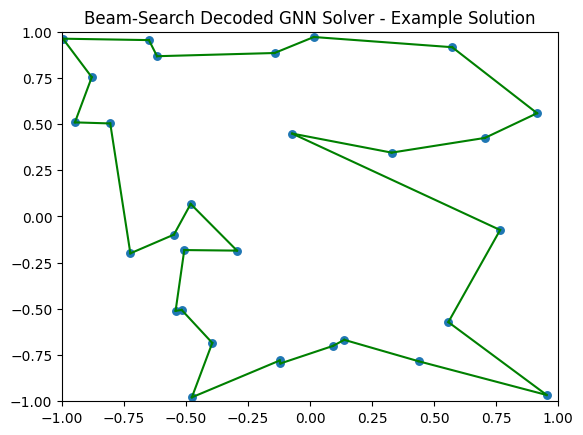

In [36]:
bsd_example_points = torch.vstack((training_dataset[0].x[:, 0], training_dataset[0].x[:, 1]))
bsd_example_data = training_dataset[0]
bsd_example_out, _ = net(bsd_example_data)
soln = beam_search_decode(
    bsd_example_points,
    bsd_example_out,
    beam_width_mapping=stepped_beam_width_function,
)
plt.title("Beam-Search Decoded GNN Solver - Example Solution")
plot_route(bsd_example_points, soln)